# Modelo de bigramas para el corpus CESS

En las aplicaciones concretas de los modelos  del lenguaje surgen diferentes problemas, tales como:

* En la estimación del modelo no se presentan todas las palabras de una lengua.
* Calcular la probabilidad de una cadena nueva que  contiene una palabra no observada en la estimación puede causar problemas.

Por tanto, aquí propondremos el uso de un símbolo UNK para manejar elementos del vocabulario que no se observaron.

In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import cess_esp
from collections import Counter,defaultdict
from itertools import chain
from sklearn.model_selection import train_test_split

### Pre-procesamiento del corpus

En primer lugar obtenemos el corpus, agregamos los símbolos de inicio BOS y final EOS, asímismo utilizaremos el símbolo UNK.

In [2]:
#nltk.download('cess_esp')

In [3]:
#Funcion que crea un vocabulario de palabras con un indice numerico
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    return vocab    

#Funcion que pasa la cadena de simbolos a una secuencia con indices numericos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w.lower()] for w in doc if w not in ['*0*','-fpa-', '3p', '-fpt-', '-fpa-']]

Separaremos el corpus en dos subconjuntos:

* Corpus de entrenamiento (70\%), a partir del cual estimaremos el modelo.
* Corpus de evaluación (30\%), a partir  del cual podremos evaluar la calidad del modelo.

In [4]:
#Split en corpus train y test
corpus, corpus_eval = train_test_split(cess_esp.sents(), test_size=0.3)

print('Número de cadenas train:',len(corpus))
print('Número de cadenas test:',len(corpus_eval))

Número de cadenas train: 4221
Número de cadenas test: 1809


Para manejar palabras que no se observen en el entrenamiento, observaremos que, en la distribución de Zipf, los elementos con frecuencia 1 (hápax legumena) son poco relevantes para la  estimación del modelo. Lo que haremos será sustituir estos elementos por un símbolo OOV. Es decir, trabajaremos estas palabras como elementos desconocidos. Así, cada vez que el modelo no reconozca un elemento lo enviará al símbolo OOV.

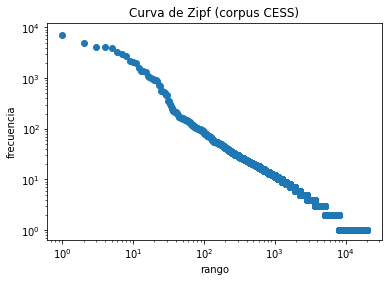

In [5]:
#Frecuencia de los tipos
freq_words= Counter( chain(*[' '.join(sent).lower().split() for sent in corpus]) )

#Ploteo de la curva de zipf
plt.plot(sorted(freq_words.values(), reverse=True), 'o')
plt.xlabel('rango')
plt.ylabel('frecuencia')
plt.xscale('log')
plt.yscale('log')
plt.title('Curva de Zipf (corpus CESS)')
plt.show()

In [6]:
#Nuevo corpus remplazando hápax por OOV
corpus_hapax = []
#Reemplazamos los hápax por OOV
for sent in corpus:
  sent_hapax =[]
  for w in sent:
    #Si es hápax
    if freq_words[w.lower()] == 1:
      #Se reemplaza por <oov>
      sent_hapax.append('<oov>')
    else:
      #De otra forma se mantiene la palabra en mínuscula
      sent_hapax.append(w.lower())
  #Se agrupan las cadenas    
  corpus_hapax.append(sent_hapax)

Podemos observar que el texto ahora tendrá símonolos OOV sustituyendo a ciertas palabras hápax

In [7]:
for sent in corpus_hapax[:10]:
  print(' '.join(sent))

" <oov> " <oov> es el rey de la velocidad explosiva y el " <oov> " el de la <oov> .
ocurre , sencillamente , que *0* no se pueden ver , que *0* se tienen manía , que uno y otro se hallan <oov> .
el aplazamiento de los comicios fue <oov> además por la misión de observadores electorales de la organización_de_estados_americanos -fpa- oea -fpt- , para poder probar el programa informático de <oov> de votos que se usará en la nueva elección .
el brazo , por_ejemplo , presenta el pelo curiosamente vuelto hacia arriba , detalle que han explicado los científicos <oov> que sólo así <oov> el <oov> que el agua de la lluvia llegue hasta sus manos y *0* le <oov> sus movimientos usuales .
la jornada también dejó para el recuerdo la goleada de la real_sociedad sobre el athletic -fpa- <oov> -fpt- en el duelo vasco y un nuevo <oov> del atlético_de_madrid , esta vez en casa frente_al málaga -fpa- <oov> -fpt- .
garcía explicó que las compañías de telecomunicaciones pueden lograr un ahorro de hasta el 60_p

Ahora indexamos las palabras

In [8]:
voc = vocab()
#Creamos el vocabulario y le asignamos un indice a cada simbolo segun su aparicion
cads_idx = list(text2numba(corpus_hapax,voc))

print(cads_idx[:10])

[[0, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 3, 0, 1, 0, 3, 5, 6, 1, 10], [11, 12, 13, 12, 14, 15, 16, 17, 18, 12, 14, 16, 19, 20, 12, 14, 21, 9, 22, 16, 23, 1, 10], [3, 24, 5, 25, 26, 27, 1, 28, 29, 6, 30, 5, 31, 32, 5, 6, 33, 34, 12, 35, 36, 37, 3, 38, 39, 5, 1, 5, 40, 14, 16, 41, 42, 6, 43, 44, 10], [3, 45, 12, 46, 12, 47, 3, 48, 49, 50, 51, 52, 12, 53, 14, 54, 55, 25, 56, 1, 14, 57, 58, 1, 3, 1, 14, 3, 59, 5, 6, 60, 61, 62, 63, 64, 9, 65, 1, 63, 66, 67, 10], [6, 68, 69, 70, 35, 3, 71, 6, 72, 5, 6, 73, 74, 3, 75, 1, 42, 3, 76, 77, 9, 78, 79, 1, 80, 81, 12, 82, 83, 42, 84, 85, 86, 1, 10], [87, 88, 14, 89, 90, 5, 91, 17, 92, 78, 93, 5, 62, 3, 94, 95, 96, 42, 97, 98, 99, 12, 9, 57, 100, 101, 102, 103, 104, 105, 74, 6, 106, 12, 80, 107, 3, 108, 9, 80, 109, 3, 110, 10], [6, 111, 112, 113, 42, 1, 1, 9, 114, 1, 42, 6, 115, 5, 1, 1, 116, 3, 1, 10], [6, 7, 12, 102, 117, 83, 12, 118, 119, 120, 121, 1, 25, 122, 12, 1, 3, 123, 16, 1, 51, 3, 124, 120, 51, 3, 97, 10], [0, 6, 125, 120, 6, 1, 126, 78, 127

Agregamos los símbolos de inicio BOS y fin EOS

In [9]:
#Indicamos las etiquetas a usar
EOS = '<EOS>'
BOS = '<BOS>'

#Cada etiqeuta se le asigna un indice numerico
BOS_IDX = max(voc.values())+2
EOS_IDX = max(voc.values())+1

#Se agregan estas etiqeutas al vocabulario
voc[EOS] = EOS_IDX
voc[BOS] = BOS_IDX

#A cada cadena se le agrega la etiqueta BOS al inicio y EOS al final
cadenas = [[BOS_IDX] + cad + [EOS_IDX] for cad in cads_idx]

print(cadenas[:3])

[[8139, 0, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 3, 0, 1, 0, 3, 5, 6, 1, 10, 8138], [8139, 11, 12, 13, 12, 14, 15, 16, 17, 18, 12, 14, 16, 19, 20, 12, 14, 21, 9, 22, 16, 23, 1, 10, 8138], [8139, 3, 24, 5, 25, 26, 27, 1, 28, 29, 6, 30, 5, 31, 32, 5, 6, 33, 34, 12, 35, 36, 37, 3, 38, 39, 5, 1, 5, 40, 14, 16, 41, 42, 6, 43, 44, 10, 8138]]


In [10]:
#Tamaño
N = len(voc)-2
print('Tamaño del vocabulario:', N)

Tamaño del vocabulario: 8138


Y, finalmente, obtenemos los bigramas de estos índices:

In [11]:
#Se crean los bigramas
bigrams = list(chain(*[zip(cad,cad[1:]) for cad in cadenas]))

#Se obtiene la frecuencia de cada bigrama
frecBigrams = Counter(bigrams)

print('Número de bigramas:', len(bigrams))
print('Ejemplos:', bigrams[:10])

Número de bigramas: 134691
Ejemplos: [(8139, 0), (0, 1), (1, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7)]


### Estimación del modelo

Obtendremos, en primer lugar, matrices de frecuenncias. A partir de estas frecuencias es que estimaremos las probabilidades con smoothing.

In [12]:
#La matriz A es de NxN+1, los renglones consideran EOS
A_frec = np.zeros((N,N+1))

#Pi es de tamano N
Pi_frec = np.zeros(N)

In [13]:
#Llenamos con frecuencias
for bigram,frec in frecBigrams.items():
    #Matriz de transición  
    if bigram[0] != BOS_IDX:
        A_frec[bigram[0],bigram[1]] = frec
    elif bigram[0] == BOS_IDX:
        #Vector de iniciales
        Pi_frec[bigram[1]] = frec

In [14]:
print(A_frec)

[[  1. 203.  27. ...   0.   0.   5.]
 [295. 716.  32. ...   0.   0.   5.]
 [ 12.  42.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


Ahora, definimos un estimador de Lidstone, de tal forma que podamos ajustar el parámetro de $\lambda$ para minimizar la entropía del modelo.

In [15]:
#Definicion de estimador Lidstone
def get_model_Lid(frec_trans, frec_init, l=0.0):
    #Añadir parámetro
    addA = frec_trans + l
    addPi = frec_init + l
    
    #Obtener probabilidades de transición
    mu_A = addA.T/addA.T.sum(0)
    #Obtener probabilidades de inicio
    mu_Pi = addPi.T/addPi.T.sum(0)
    
    return (mu_A.T,mu_Pi)

### Evaluación

Asimismo, definimos una función de entropía que evaluará la pertinencia de un modelo. Esta evaluación se hará sobre el **corpus de evaluación**; es decir, sobre cadenas que no fueron observadas para estimar las probabilidades.

In [16]:
#Función de evaluación
def H(mu):
    #Entropía
    H = 0.0
    for cad in corpus_eval:
        #Probabilidad de la cadena
        p_cad = prob_cad(' '.join(cad),mu)
        #Número de bigramas
        M = len(cad)
        #Obtenemos la entropía cruzada de la cadena
        if p_cad == 0:
          pass #print(np.log(p_cad), p_cad, cad)
        else:
          H -= np.log(p_cad)/M       
    
    return H/len(corpus_eval)

Definiremos una función de cálculo de probabilidad de cadena. En este caso, consideramos como UNK a aquellas palabras que no han sido  vistas en la estimación del modelo.

In [17]:
#Diccionario para recuperar palabras a partir de sus índices
get_word = {i:w for w,i in voc.items()}

def prob_cad(cad,mu,unk=False):
    #Matrices del modelo
    A_mu, Pi_mu = mu
    #Evita generar unk's
    if unk==True:
      A = A_mu
      A[voc['<oov>']] = np.zeros(N+1)
      A.T[voc['<oov>']] = np.zeros(N)
    else:
      A = A_mu
    #Obtenemos los simbolos
    seq = cad.split()
    #Obtenemos los bigramas de la cadena de evaluacion
    bigrSeq = zip(seq,seq[1:])
    
    #Guardamos la probabilidad inicial dado el modelo
    if voc[seq[0]] > N+1:
      p = Pi_mu[voc['<oov>']]
    else:
      p = Pi_mu[voc[seq[0]]]
    #Multiplicamos por las probabilidades de los bigramas dado el modelo
    for gram1,gram2 in bigrSeq:
        if voc[gram1] > N+1:
          gram1 = '<oov>'
        if voc[gram2] > N+1:
          gram2 = '<oov>'

        p *= A[voc[gram1],voc[gram2]]
    
    return p 

Ahora, podemos observar cómo es que varía la entropía según la elección del parámetro $\lambda$ en el smoothing de Lidstone.

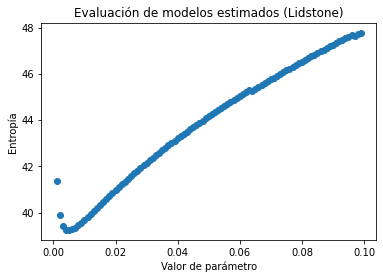

In [18]:
#Guarda valores de entropía
rank_H = []
for i in range(1,100):
    #rango de 0.01 a 2
    k = float(i)/1000
    #obtiene los valores de entropia
    rank_H.append( (k,H(get_model_Lid(A_frec,Pi_frec,l=k))) )

#Visualización
rank_H = np.array(rank_H)
plt.scatter(rank_H[:,0],2**rank_H[:,1])
plt.xlabel('Valor de parámetro')
plt.ylabel('Entropía')
plt.title('Evaluación de modelos estimados (Lidstone)')
plt.show()

Podemos ver cuál es el parámetro que minimiza más la entropía:

In [19]:
#Parámetro con etnropía mínima
l_min = rank_H[:,0][np.argmin(rank_H[:,1])]

print(l_min)

0.005


A partir de esto, podemos estimar el modelo:

In [20]:
A_lid,Pi_lid = get_model_Lid(A_frec,Pi_frec,l=l_min)

In [21]:
print(A_lid.sum(1))
print(Pi_lid.sum(0))

[1. 1. 1. ... 1. 1. 1.]
1.0000000000000004


In [22]:
#Cadenas de ejemplo
string1 = 'la operación de compra o fusión'
string2 = 'los hechos han sido insuficientes'
string3 = 'los hechos sido han insuficientes'
string4 = 'hechos los sido han insuficientes'

#Probabilidad de cadenas
print( 'cadena:', string1, 'prob:', prob_cad(string1, (A_lid, Pi_lid)) )
print( 'cadena:', string2, 'prob:', prob_cad(string2, (A_lid, Pi_lid)) )
print( 'cadena:', string3, 'prob:', prob_cad(string3, (A_lid, Pi_lid)) )
print( 'cadena:', string4, 'prob:', prob_cad(string4, (A_lid, Pi_lid)) )

cadena: la operación de compra o fusión prob: 1.1508116309972821e-12
cadena: los hechos han sido insuficientes prob: 5.0046311873486314e-15
cadena: los hechos sido han insuficientes prob: 1.3897892772420525e-18
cadena: hechos los sido han insuficientes prob: 2.3047146807246597e-25


Finalmente, podemos obtener la evaluación del modelo en entropía y perplejidad:

In [23]:
print('Entropía: {} \nPerplejidad: {}'.format(H((A_lid, Pi_lid)), 2**H((A_lid, Pi_lid))))

Entropía: 5.293727287476545 
Perplejidad: 39.22569999004139


### Generación aleatoria de cadenas

Para la generación de cadenas se puede tomar la palabra que maximice la probabilidad dada la cadena anterior; sin embargo, esto no garantiza que la cadena completa sea la que tiene mayor  probabilidad.

Otra forma de generar cadenas es de manera aleatoria. En este caso, se tomara una palabra siguiente de forma aleatoria y en base a la distribución de probabilidad $p(x|w)$ donde $w$ es la última palabra en la cadena. Esta forma de generar lenguaje permite que las cadenas sean no determinísticas.

In [24]:
def next_word(string, mu):
    #Elementos del modelo
    A, Pi = mu
    #Obtener la probabilidad de la historia
    p_prev = prob_cad(string, mu, unk=True)
    #Obtener la última palabra en la historia
    last_w = string.split()[-1]
    #Obtener una palabra en base a la distribución
    #max_w = np.random.choice(list(voc.values())[:N+1], p=A[voc[last_w]]/A[voc[last_w]].sum(0))
    max_w = np.argmax(A[voc[last_w]])
    
    return get_word[max_w], A[voc[last_w],max_w]

def generate(string, mu):
    #Guarda la palabra predicha
    w = ''
    #Guarda la cadena que se ha generado
    str_gen = string
    #El método se detiene al ver <EOS>
    t = 0
    while w != '<EOS>':
        #Predice la siguiente palabra
        w, p = next_word(str_gen, mu)
        #Agrega esa palabra a ala cadena
        str_gen += ' ' + w
        t += 1
        if t == 100:
          w = '<EOS>'
    
    #Regresa la cadena si el símbolo EOS
    return str_gen[:len(str_gen)]

In [25]:
print( generate('país', (A_lid, Pi_lid)) )

país , que se ha sido el presidente de la que se ha sido el presidente de la que se ha sido el presidente de la que se ha sido el presidente de la que se ha sido el presidente de la que se ha sido el presidente de la que se ha sido el presidente de la que se ha sido el presidente de la que se ha sido el presidente de la que se ha sido el presidente de la que se ha sido el presidente de la que se ha sido el presidente de la que se ha
